In [1]:
import pandas as pd
import numpy as np
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, RandomOverSampler
from collections import Counter

print("라이브러리 로드 완료!")

라이브러리 로드 완료!


In [3]:
import os

# 자동으로 바탕화면 경로 찾기
desktop = os.path.join(os.path.expanduser('~'), 'Desktop')
base_path = os.path.join(desktop, 'data') + '\\'

print(f"경로: {base_path}")

try:
    df_screen = pd.read_excel(base_path + 'screening_data_1001.xlsx')
    df_snsb = pd.read_excel(base_path + 'SNSB_1000.xlsx')
    df_apoe = pd.read_excel(base_path + 'APOE_982.xlsx')
    df_pet = pd.read_excel(base_path + 'PET_result_300.xlsx')

    mri_path = base_path + 'mri_roi_992.xlsx'
    df_mri_sub = pd.read_excel(mri_path, sheet_name='subcortical')
    df_mri_surf = pd.read_excel(mri_path, sheet_name='surface')
    df_mri_thick = pd.read_excel(mri_path, sheet_name='thickness')
    print("불러오기 성공")

except FileNotFoundError as e:
    print(f"[에러] {e}")
    raise

경로: C:\Users\USER\Desktop\data\
불러오기 성공


In [4]:
if 'SubjectID' in df_screen.columns:
    df_screen = df_screen.rename(columns={'SubjectID': 'ID'})

dfs = [df_snsb, df_apoe, df_pet, df_mri_sub, df_mri_surf, df_mri_thick]
for df in dfs:
    if 'Subject ID' in df.columns:
        df.rename(columns={'Subject ID': 'ID'}, inplace=True)
    elif 'Subject_ID' in df.columns:
        df.rename(columns={'Subject_ID': 'ID'}, inplace=True)

drop_cols = ['순번', 'MRI ID', 'NO']
df_mri = df_mri_sub.drop(columns=drop_cols, errors='ignore') \
    .merge(df_mri_surf.drop(columns=drop_cols, errors='ignore'), on='ID', how='outer') \
    .merge(df_mri_thick.drop(columns=drop_cols, errors='ignore'), on='ID', how='outer')

df_master = df_screen.merge(df_snsb.drop(columns=['순번'], errors='ignore'), on='ID', how='left') \
                     .merge(df_apoe.drop(columns=['NO', '순번'], errors='ignore'), on='ID', how='left') \
                     .merge(df_mri, on='ID', how='left') \
                     .merge(df_pet.drop(columns=['순번'], errors='ignore'), on='ID', how='left')

print(f"데이터 통합 완료 --> 전체 샘플 수: {len(df_master)}")

데이터 통합 완료 --> 전체 샘플 수: 1001


In [5]:
target_mapping = {'CN': 0, 'SCD': 1, 'MCI': 2, 'Dem': 3}
df_master['target'] = df_master['DIA_01'].map(target_mapping)
df_master = df_master.dropna(subset=['target'])

cols_to_drop = ['ID', 'SubjectID', 'Num', 'Selection_num', 'test_day', 'Date',
                'DIA_01', 'target', 'MRI_ID', 'PET ID', '검사일자', '순번']
feature_cols = [c for c in df_master.columns if c not in cols_to_drop]

if '아밀로이드 베타' in df_master.columns:
    df_master['has_PET'] = df_master['아밀로이드 베타'].notnull().astype(int)
    feature_cols.append('has_PET')

def check_e4(x):
    if pd.isna(x): return 0
    return 1 if 'e4' in str(x).lower() else 0

if 'APOE' in df_master.columns:
    df_master['APOE_e4'] = df_master['APOE'].apply(check_e4)
    feature_cols.append('APOE_e4')

df_train = df_master.copy()
for col in feature_cols:
    if df_train[col].dtype in ['int64', 'float64']:
        mean_val = df_train[col].mean()
        df_train[col] = df_train[col].fillna(0 if pd.isna(mean_val) else mean_val)
    else:
        df_train[col] = df_train[col].fillna("Unknown")
        le = LabelEncoder()
        df_train[col] = le.fit_transform(df_train[col].astype(str))

if df_train[feature_cols].isnull().sum().sum() > 0:
    df_train[feature_cols] = df_train[feature_cols].fillna(0)

X = df_train[feature_cols].values.astype('float32')
y = df_train['target'].values.astype(int)

print(f"전처리 완료 --> Feature 수: {len(feature_cols)}")

전처리 완료 --> Feature 수: 515


In [6]:
print("\n" + "="*50)
print("원본 데이터 클래스 분포")
print("="*50)

class_names = ['CN', 'SCD', 'MCI', 'Dem']
original_dist = Counter(y)

for idx, name in enumerate(class_names):
    count = original_dist[idx]
    pct = count / len(y) * 100
    bar = '█' * int(pct / 2)
    print(f"{name:>5}: {count:>4}개 ({pct:>5.1f}%) {bar}")

print(f"\n총 샘플 수: {len(y)}개")


원본 데이터 클래스 분포
   CN:  607개 ( 61.4%) ██████████████████████████████
  SCD:   36개 (  3.6%) █
  MCI:  302개 ( 30.5%) ███████████████
  Dem:   44개 (  4.4%) ██

총 샘플 수: 989개


In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("분할 후 클래스 분포:")
print(f"  Train: {Counter(y_train)}")
print(f"  Valid: {Counter(y_valid)}")
print(f"  Test:  {Counter(y_test)}")

분할 후 클래스 분포:
  Train: Counter({np.int64(0): 425, np.int64(2): 211, np.int64(3): 31, np.int64(1): 25})
  Valid: Counter({np.int64(0): 91, np.int64(2): 45, np.int64(1): 6, np.int64(3): 6})
  Test:  Counter({np.int64(0): 91, np.int64(2): 46, np.int64(3): 7, np.int64(1): 5})


In [8]:
print("\n" + "="*50)
print("SCD 클래스 강화 증강 시작!")
print("="*50)

train_dist = Counter(y_train)
print(f"\n증강 전 Train 분포: {dict(train_dist)}")

print("\n[Step 1] RandomOverSampler로 SCD 기본 증강")

target_scd_count = train_dist[2]
sampling_strategy_step1 = {
    0: train_dist[0],
    1: target_scd_count,
    2: train_dist[2],
    3: train_dist[3]
}

ros = RandomOverSampler(sampling_strategy=sampling_strategy_step1, random_state=42)
X_train_step1, y_train_step1 = ros.fit_resample(X_train, y_train)
print(f"  -> Step 1 결과: {dict(Counter(y_train_step1))}")

print("\n[Step 2] ADASYN으로 경계 샘플 강화")

try:
    adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=3)
    X_train_res, y_train_res = adasyn.fit_resample(X_train_step1, y_train_step1)
    print("  -> ADASYN 성공")
except Exception as e:
    print(f"  -> ADASYN 실패, BorderlineSMOTE로 대체: {e}")
    bsmote = BorderlineSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=3)
    X_train_res, y_train_res = bsmote.fit_resample(X_train_step1, y_train_step1)

print(f"\n최종 증강 결과: {dict(Counter(y_train_res))}")

print("\n클래스별 증강 비율:")
final_dist = Counter(y_train_res)
for idx, name in enumerate(class_names):
    before = train_dist[idx]
    after = final_dist[idx]
    ratio = after / before if before > 0 else 0
    print(f"  {name}: {before}개 → {after}개 (x{ratio:.1f})")


SCD 클래스 강화 증강 시작!

증강 전 Train 분포: {np.int64(2): 211, np.int64(0): 425, np.int64(3): 31, np.int64(1): 25}

[Step 1] RandomOverSampler로 SCD 기본 증강
  -> Step 1 결과: {np.int64(2): 211, np.int64(0): 425, np.int64(3): 31, np.int64(1): 211}

[Step 2] ADASYN으로 경계 샘플 강화
  -> ADASYN 실패, BorderlineSMOTE로 대체: Not any neigbours belong to the majority class. This case will induce a NaN case with a division by zero. ADASYN is not suited for this specific dataset. Use SMOTE instead.

최종 증강 결과: {np.int64(2): 425, np.int64(0): 425, np.int64(3): 425, np.int64(1): 425}

클래스별 증강 비율:
  CN: 425개 → 425개 (x1.0)
  SCD: 25개 → 425개 (x17.0)
  MCI: 211개 → 425개 (x2.0)
  Dem: 31개 → 425개 (x13.7)


In [9]:
print("\nClass Weight 계산")

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_res),
    y=y_train_res
)

class_weights[1] *= 1.5

class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print(f"Class Weights: {class_weight_dict}")

sample_weights = np.array([class_weight_dict[label] for label in y_train_res])


Class Weight 계산
Class Weights: {0: np.float64(1.0), 1: np.float64(1.5), 2: np.float64(1.0), 3: np.float64(1.0)}


In [10]:
print("\n" + "="*50)
print("앙상블 학습 시작! (총 5회 반복)")
print("="*50)

seeds = [42, 2023, 2024, 777, 999]
preds_test_probs = []
models = []

for i, seed in enumerate(seeds):
    print(f"\n[Model {i+1}/5] 학습 중 (Seed={seed})")

    clf = TabNetClassifier(
        n_d=64, n_a=64, n_steps=5,
        gamma=1.2,
        n_independent=2, n_shared=2,
        lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=1e-2),
        scheduler_params={"step_size":20, "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='entmax',
        seed=seed,
        verbose=0
    )

    clf.fit(
        X_train=X_train_res, y_train=y_train_res,
        eval_set=[(X_valid, y_valid)],
        eval_name=['valid'],
        eval_metric=['balanced_accuracy'],
        max_epochs=150,
        patience=40,
        batch_size=256,
        virtual_batch_size=32,
        num_workers=0,
        drop_last=False,
        weights=sample_weights
    )

    pred_prob = clf.predict_proba(X_test)
    preds_test_probs.append(pred_prob)
    models.append(clf)
    print(f"  -> 완료! Best Valid Score: {clf.best_cost:.4f}")


앙상블 학습 시작! (총 5회 반복)

[Model 1/5] 학습 중 (Seed=42)

Early stopping occurred at epoch 81 with best_epoch = 41 and best_valid_balanced_accuracy = 0.54243


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> 완료! Best Valid Score: 0.5424

[Model 2/5] 학습 중 (Seed=2023)

Early stopping occurred at epoch 112 with best_epoch = 72 and best_valid_balanced_accuracy = 0.57002


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> 완료! Best Valid Score: 0.5700

[Model 3/5] 학습 중 (Seed=2024)

Early stopping occurred at epoch 100 with best_epoch = 60 and best_valid_balanced_accuracy = 0.64219


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> 완료! Best Valid Score: 0.6422

[Model 4/5] 학습 중 (Seed=777)

Early stopping occurred at epoch 106 with best_epoch = 66 and best_valid_balanced_accuracy = 0.56999


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> 완료! Best Valid Score: 0.5700

[Model 5/5] 학습 중 (Seed=999)

Early stopping occurred at epoch 103 with best_epoch = 63 and best_valid_balanced_accuracy = 0.6199


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> 완료! Best Valid Score: 0.6199


In [11]:


avg_preds_proba = np.mean(preds_test_probs, axis=0)
final_preds = np.argmax(avg_preds_proba, axis=1)

final_f1 = f1_score(y_test, final_preds, average='macro')
final_acc = accuracy_score(y_test, final_preds)

print(f"\n앙상블 최종 Macro F1 Score: {final_f1:.4f}")
print(f"앙상블 최종 Accuracy: {final_acc:.4f}")
print("\n" + classification_report(y_test, final_preds, target_names=class_names, zero_division=0))


앙상블 최종 Macro F1 Score: 0.4524
앙상블 최종 Accuracy: 0.7383

              precision    recall  f1-score   support

          CN       0.83      0.85      0.84        91
         SCD       0.00      0.00      0.00         5
         MCI       0.61      0.67      0.64        46
         Dem       0.40      0.29      0.33         7

    accuracy                           0.74       149
   macro avg       0.46      0.45      0.45       149
weighted avg       0.71      0.74      0.72       149



In [12]:
print("\n" + "="*50)
print("SCD 임계값 최적화 시작...")
print("="*50)

best_score = final_f1
best_th = 0.5
best_preds = final_preds.copy()

for th in np.arange(0.10, 0.50, 0.05):
    temp_preds = []
    for probs in avg_preds_proba:
        if probs[1] >= th:
            temp_preds.append(1)
        else:
            temp_preds.append(np.argmax(probs))

    score = f1_score(y_test, temp_preds, average='macro')

    if score > best_score:
        best_score = score
        best_th = th
        best_preds = temp_preds

if best_th != 0.5:
    print(f"\nSCD 최적 임계값 발견: {best_th:.2f}")
    print(f"   (SCD 확률이 {best_th*100:.0f}% 이상이면 SCD로 분류)")
else:
    print("\n임계값 조정 없이 기본값 사용")

print("\n" + "="*50)
print(f"최종 Macro F1 Score: {best_score:.4f}")
print("="*50)
print(classification_report(y_test, best_preds, target_names=class_names, zero_division=0))


SCD 임계값 최적화 시작...

임계값 조정 없이 기본값 사용

최종 Macro F1 Score: 0.4524
              precision    recall  f1-score   support

          CN       0.83      0.85      0.84        91
         SCD       0.00      0.00      0.00         5
         MCI       0.61      0.67      0.64        46
         Dem       0.40      0.29      0.33         7

    accuracy                           0.74       149
   macro avg       0.46      0.45      0.45       149
weighted avg       0.71      0.74      0.72       149



In [13]:
print("\n" + "="*50)
print("SCD 증강 효과 요약")
print("="*50)

class_f1 = f1_score(y_test, best_preds, average=None, zero_division=0)

print("\n클래스별 F1 Score:")
for idx, name in enumerate(class_names):
    f1 = class_f1[idx]
    bar = '█' * int(f1 * 20)
    status = "✅" if f1 >= 0.5 else "⚠️" if f1 >= 0.3 else "❌"
    print(f"  {name:>5}: {f1:.3f} {bar} {status}")

print(f"\n  Macro F1: {best_score:.4f}")


SCD 증강 효과 요약

클래스별 F1 Score:
     CN: 0.837 ████████████████ ✅
    SCD: 0.000  ❌
    MCI: 0.639 ████████████ ✅
    Dem: 0.333 ██████ ⚠️

  Macro F1: 0.4524


In [14]:
import os

save_models = True

if save_models:
    save_path = './models_augmented/'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        print(f"폴더 생성: {save_path}")

    for i, (model, seed) in enumerate(zip(models, seeds)):
        filename = f'tabnet_scd_augmented_seed_{seed}'
        saved_path = model.save_model(save_path + filename)
        print(f"  [{i+1}/5] 저장 완료: {saved_path}")

    print("\n모델 저장 완료")

폴더 생성: ./models_augmented/
Successfully saved model at ./models_augmented/tabnet_scd_augmented_seed_42.zip
  [1/5] 저장 완료: ./models_augmented/tabnet_scd_augmented_seed_42.zip
Successfully saved model at ./models_augmented/tabnet_scd_augmented_seed_2023.zip
  [2/5] 저장 완료: ./models_augmented/tabnet_scd_augmented_seed_2023.zip
Successfully saved model at ./models_augmented/tabnet_scd_augmented_seed_2024.zip
  [3/5] 저장 완료: ./models_augmented/tabnet_scd_augmented_seed_2024.zip
Successfully saved model at ./models_augmented/tabnet_scd_augmented_seed_777.zip
  [4/5] 저장 완료: ./models_augmented/tabnet_scd_augmented_seed_777.zip
Successfully saved model at ./models_augmented/tabnet_scd_augmented_seed_999.zip
  [5/5] 저장 완료: ./models_augmented/tabnet_scd_augmented_seed_999.zip

모델 저장 완료


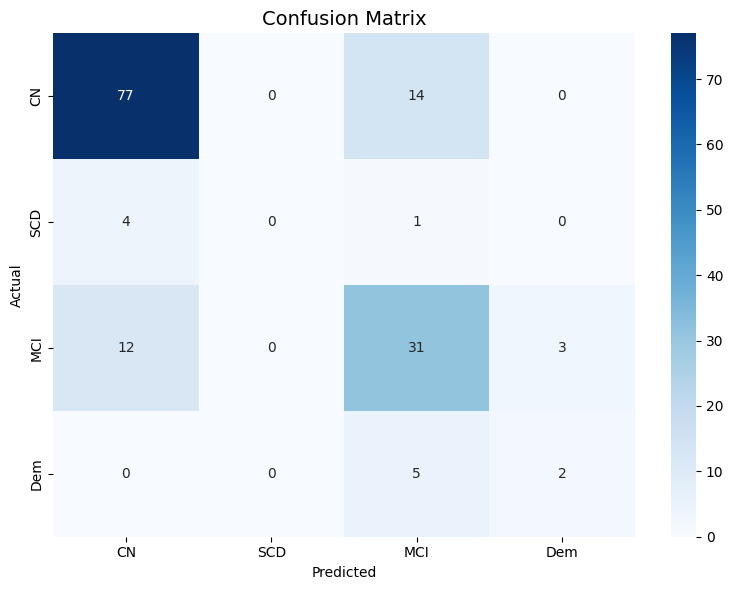


해석: 대각선 = 맞춘 것, 나머지 = 틀린 것


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print("\n해석: 대각선 = 맞춘 것, 나머지 = 틀린 것")

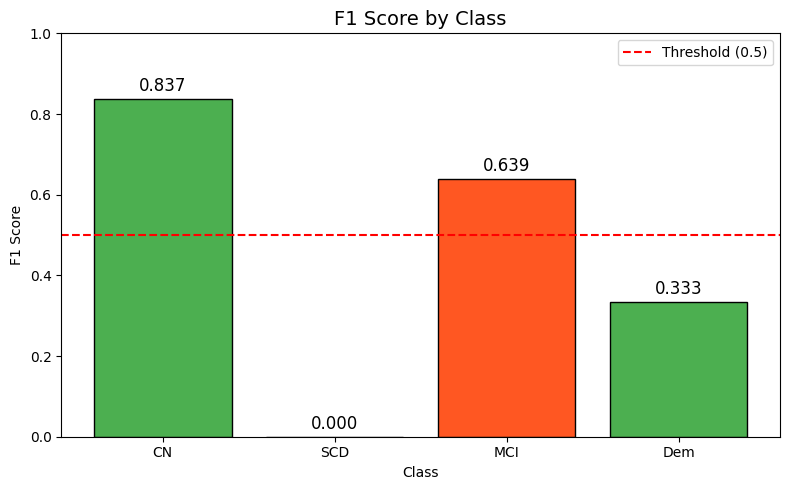

In [16]:
plt.figure(figsize=(8, 5))
colors = ['#4CAF50', '#2196F3', '#FF5722']
bars = plt.bar(class_names, class_f1, color=colors, edgecolor='black')

for bar, f1 in zip(bars, class_f1):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{f1:.3f}', ha='center', fontsize=12)

plt.ylim(0, 1.0)
plt.title('F1 Score by Class', fontsize=14)
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.axhline(y=0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.legend()
plt.tight_layout()
plt.show()

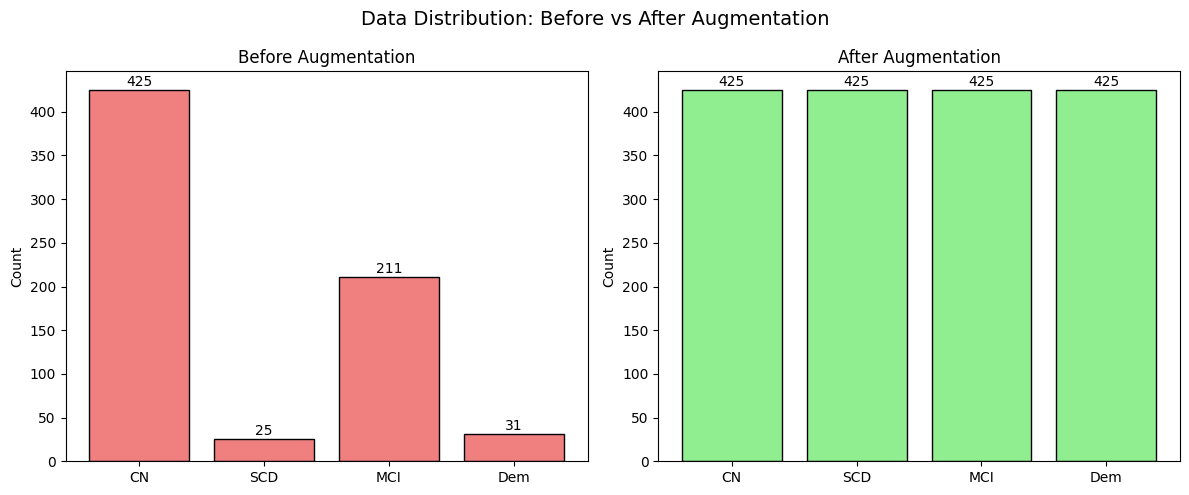

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 증강 전
ax1 = axes[0]
before_counts = [train_dist[i] for i in range(len(class_names))]
ax1.bar(class_names, before_counts, color='lightcoral', edgecolor='black')
ax1.set_title('Before Augmentation', fontsize=12)
ax1.set_ylabel('Count')
for i, v in enumerate(before_counts):
    ax1.text(i, v + 5, str(v), ha='center')

# 증강 후
ax2 = axes[1]
after_counts = [final_dist[i] for i in range(len(class_names))]
ax2.bar(class_names, after_counts, color='lightgreen', edgecolor='black')
ax2.set_title('After Augmentation', fontsize=12)
ax2.set_ylabel('Count')
for i, v in enumerate(after_counts):
    ax2.text(i, v + 5, str(v), ha='center')

plt.suptitle('Data Distribution: Before vs After Augmentation', fontsize=14)
plt.tight_layout()
plt.show()

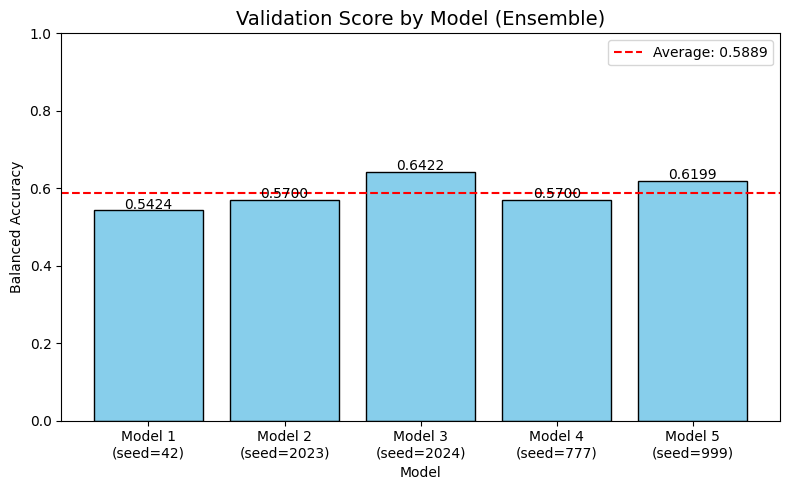

In [18]:
valid_scores = [clf.best_cost for clf in models]

plt.figure(figsize=(8, 5))
bars = plt.bar([f'Model {i+1}\n(seed={s})' for i, s in enumerate(seeds)], 
               valid_scores, color='skyblue', edgecolor='black')

for bar, score in zip(bars, valid_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{score:.4f}', ha='center', fontsize=10)

plt.ylim(0, 1.0)
plt.title('Validation Score by Model (Ensemble)', fontsize=14)
plt.xlabel('Model')
plt.ylabel('Balanced Accuracy')
plt.axhline(y=np.mean(valid_scores), color='red', linestyle='--', 
            label=f'Average: {np.mean(valid_scores):.4f}')
plt.legend()
plt.tight_layout()
plt.show()